In [148]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [149]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [150]:
NUM_CLASSES = 5

# 入力長

In [151]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [152]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [153]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [155]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [156]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 24)                792       
                                                                 
 dropout_17 (Dropout)        (None, 24)                0         
                                                                 
 dense_20 (Dense)            (None, 10)                250       
                                                                 
 dense_21 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [157]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [158]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [159]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/35 [..............................] - ETA: 13s - loss: 1.6066 - accuracy: 0.1797
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
35/35 [==============================] - 1s 5ms/step - loss: 1.5864 - accuracy: 0.2619 - val_loss: 1.5721 - val_accuracy: 0.2404
Epoch 2/1000
 1/35 [..............................] - ETA: 0s - loss: 1.5877 - accuracy: 0.1797
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
35/35 [==============================] - 0s 2ms/step - loss: 1.5605 - accuracy: 0.3011 - val_loss: 1.5387 - val_accuracy: 0.5300
Epoch 3/1000
 1/35 [..............................] - ETA: 0s - loss: 1.5401 - accuracy: 0.3672
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
35/35 [==============================] - 0s 2ms/step - loss: 1.5285 - accuracy: 0.4032 - val_loss: 1.4994 - val_accuracy: 0.5483
Epoch 4/1000
 1/35 [..............................] - ETA: 0s - lo

In [160]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [161]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 34ms/step
[2.6699944e-24 6.4758388e-03 4.1695584e-02 9.2356420e-01 2.8264411e-02]
3


# 混同行列

47/47 [==============================] - 0s 620us/step


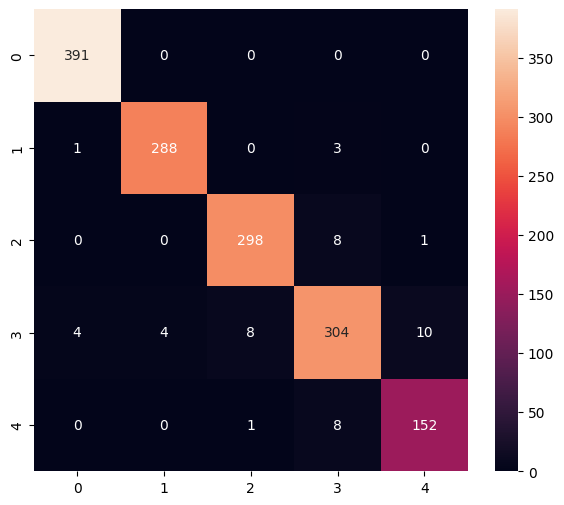

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       391
           1       0.99      0.99      0.99       292
           2       0.97      0.97      0.97       307
           3       0.94      0.92      0.93       330
           4       0.93      0.94      0.94       161

    accuracy                           0.97      1481
   macro avg       0.96      0.96      0.96      1481
weighted avg       0.97      0.97      0.97      1481



In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [163]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [164]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [165]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpb8qg_092/assets


INFO:tensorflow:Assets written to: /tmp/tmpb8qg_092/assets
2023-04-19 19:06:11.622884: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-19 19:06:11.622908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-19 19:06:11.623615: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb8qg_092
2023-04-19 19:06:11.624676: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-19 19:06:11.624691: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb8qg_092
2023-04-19 19:06:11.629864: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-19 19:06:11.644718: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb8qg_092
2023-04-19 19:06:11.648930: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6540

# 推論テスト

In [166]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [167]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_9:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [168]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [169]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 368 µs, sys: 32 µs, total: 400 µs
Wall time: 352 µs


In [170]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.6699942e-24 6.4758384e-03 4.1695599e-02 9.2356420e-01 2.8264403e-02]
3
